# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


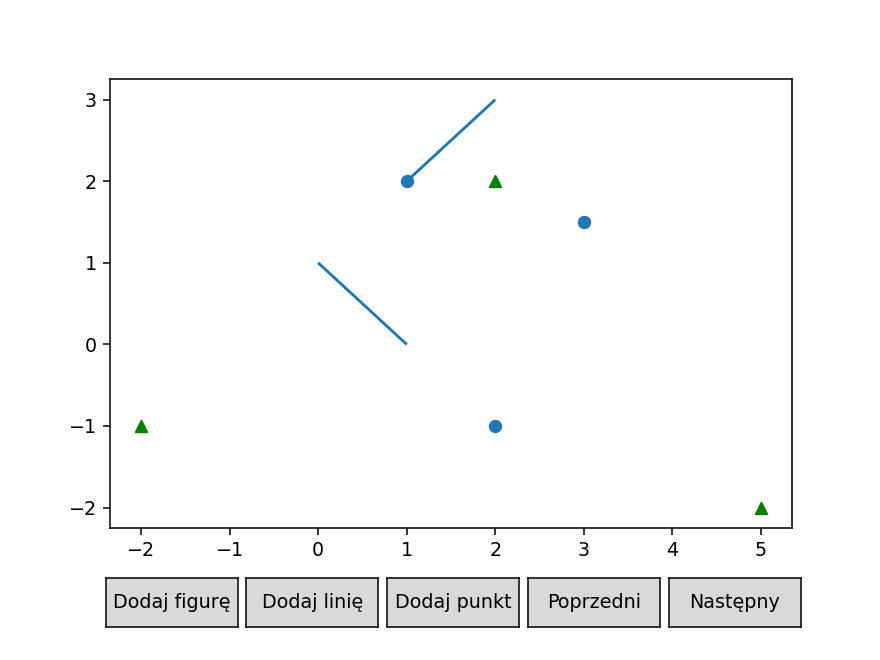

In [3]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


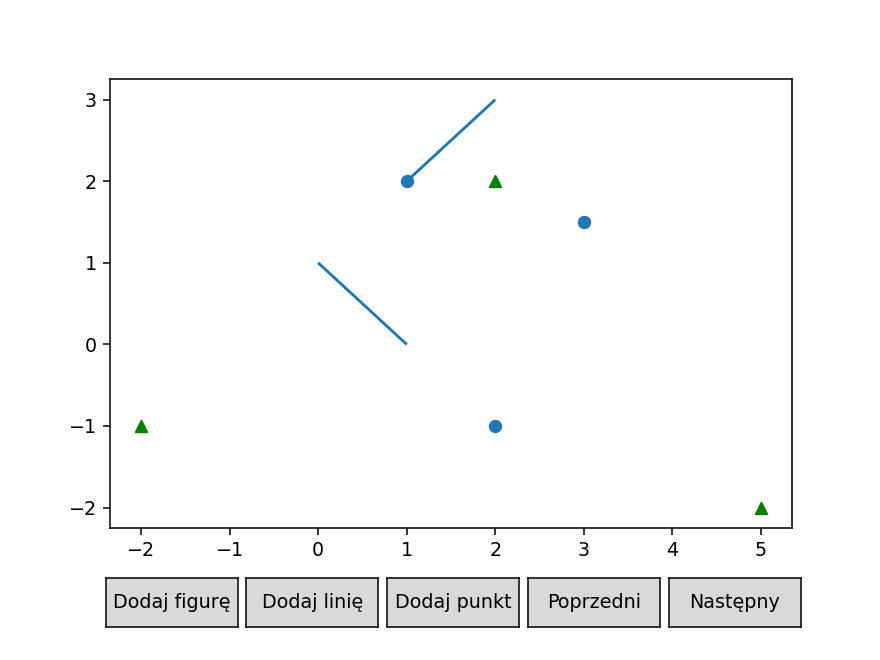

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


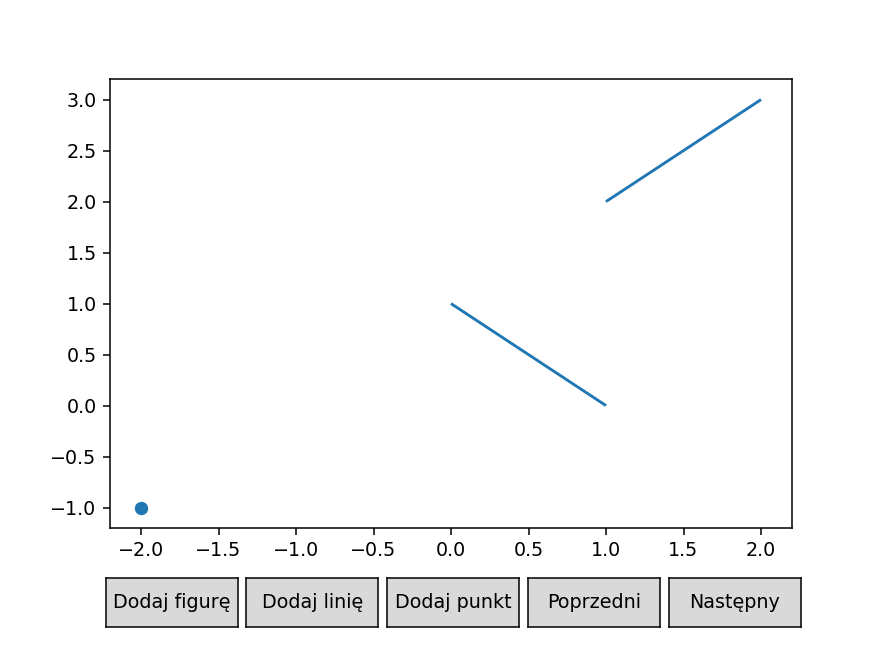

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


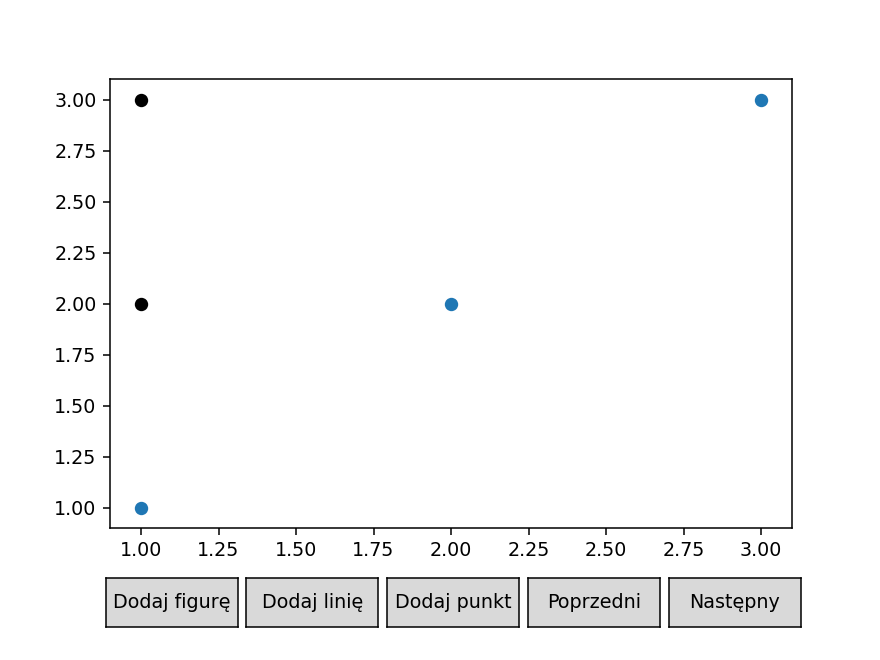

In [6]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot(points=[PointsCollection([(1, 1), (3, 3), (2, 2)]),
            PointsCollection([(1,2), (1,3)], color='black')])
plot1.draw()

<IPython.core.display.Javascript object>


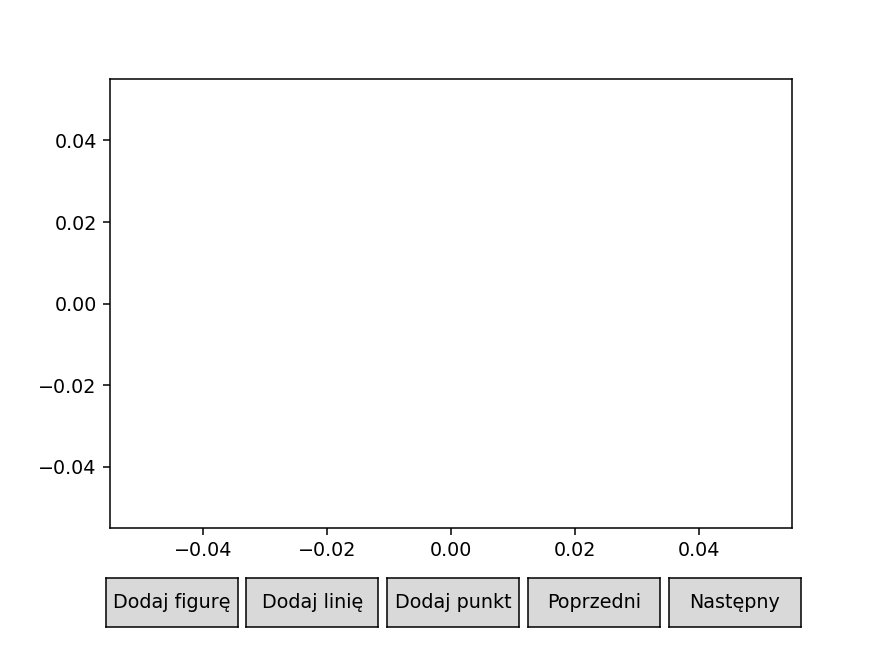

In [8]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [9]:
%matplotlib notebook

## Kolejne zestawy punktów

### a) 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

In [10]:
points_a = np.random.rand(100_000, 2) * 2000 - 1000
points_a[:5]

array([[ 105.92030713, -682.5822927 ],
       [  37.59677274, -578.74950578],
       [-841.85162827, -202.20258645],
       [-721.27485848, -684.82501608],
       [-712.93690566,  395.058572  ]])

<IPython.core.display.Javascript object>


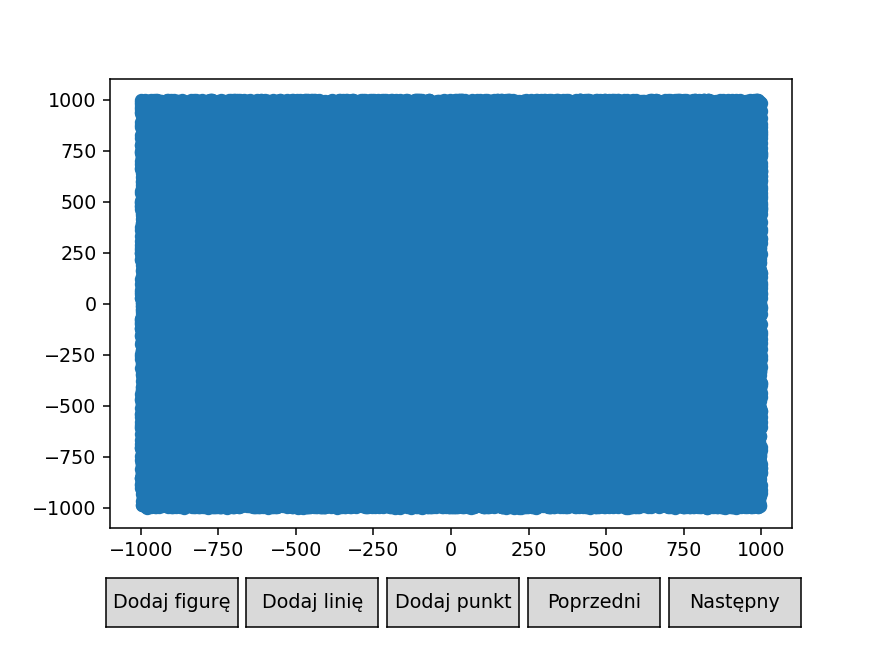

In [11]:
plot_a = Plot(points=[PointsCollection(points_a)])
plot_a.draw()

### b)10^5 losowych punktów o współrzędnych z przedziału [-10^14 , 10^14]

In [12]:
points_b = np.random.rand(100_000, 2) * 2e14 - 1e14
points_b[:5]

array([[ 3.66575123e+13, -9.95332043e+13],
       [-8.14449441e+13, -2.63356926e+13],
       [-1.93300107e+13,  3.88227332e+13],
       [ 9.08903202e+13, -7.77427811e+13],
       [-8.54150316e+13, -5.38614780e+13]])

<IPython.core.display.Javascript object>


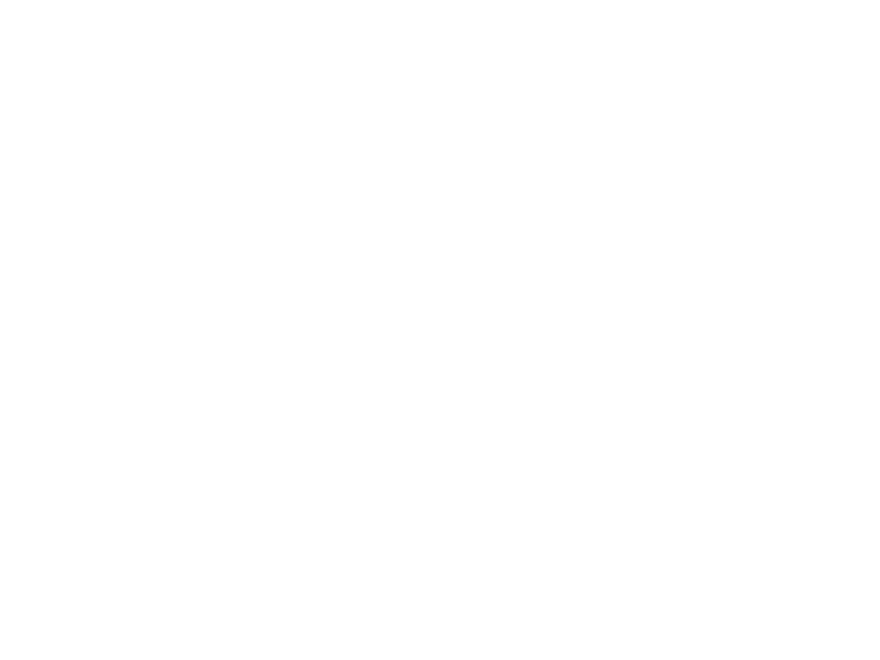

In [13]:
plot_b = Plot(points=[PointsCollection(points_b)])
plot_b.draw()

### c) 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100

In [17]:
R = 100
rand = np.random.rand(1000)
points_c = np.array([np.cos(2*np.pi * rand) * R, np.sin(2*np.pi * rand) * R]).T
points_c[:5]

array([[-81.75835106,  57.58100408],
       [ 16.1773043 , -98.68279904],
       [-77.20034849,  63.56182969],
       [ 57.8975521 , -81.53449246],
       [ 12.61421626,  99.20121747]])

<IPython.core.display.Javascript object>


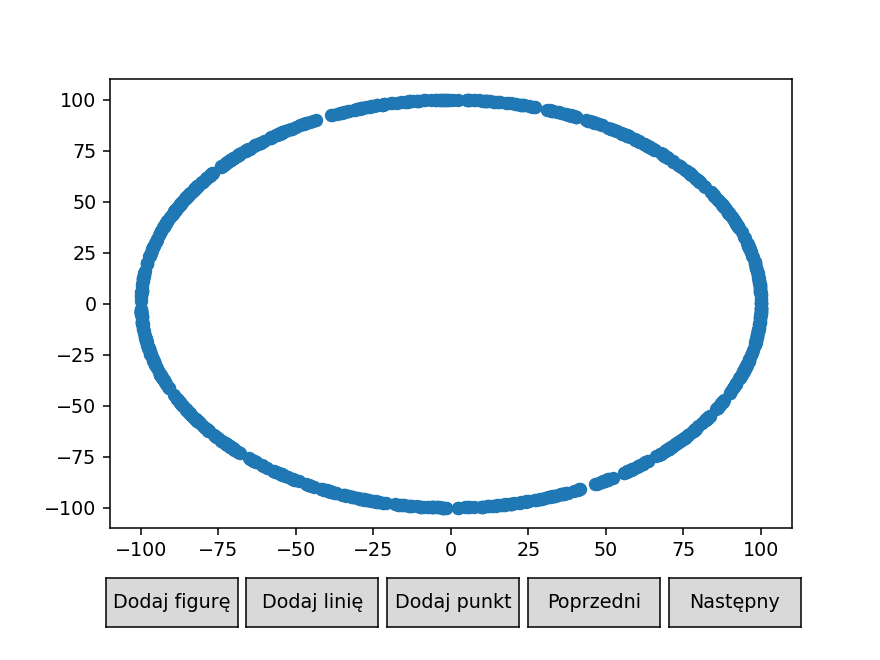

In [18]:
plot_c = Plot(points=[PointsCollection(points_c)])
plot_c.draw()

### Punkty wyznaczające wektor:

In [21]:
A = [-1.0, 0.0]
B = [1.0, 0.1]

### d) 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (p1, p2)

In [22]:
a,b = np.polyfit([A[0], B[0]], [A[1], B[1]], 1)
xs = np.random.rand(1000) * 2000 - 1000

points_d = np.array([xs, a * xs + b]).T
points_d[:5]

array([[-761.70763572,  -38.03538179],
       [-481.07454974,  -24.00372749],
       [-364.11103933,  -18.15555197],
       [ 729.73943538,   36.53697177],
       [ 271.13180546,   13.60659027]])

<IPython.core.display.Javascript object>


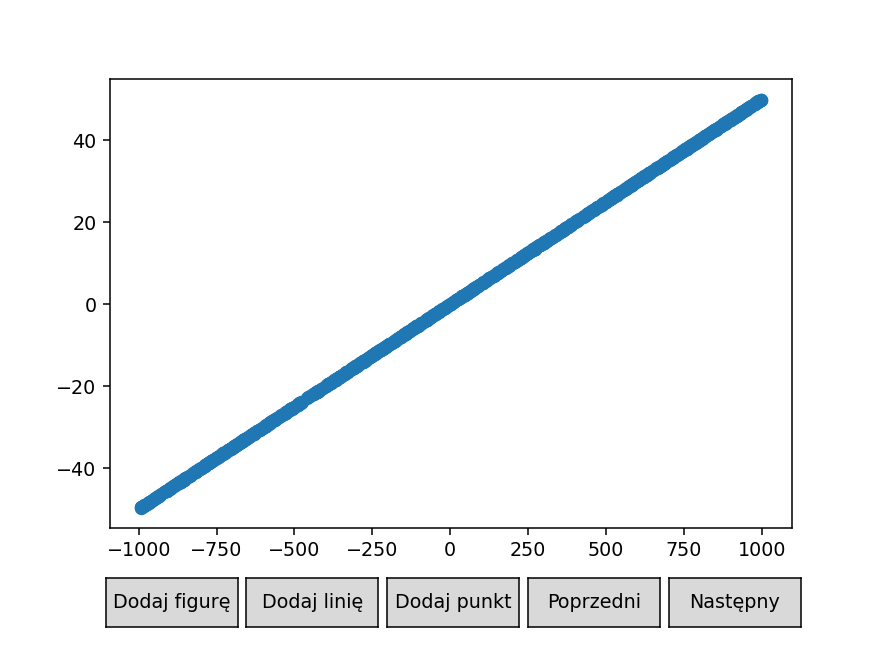

In [23]:
plot_d = Plot(points=[PointsCollection(points_d)])
plot_d.draw()

### Własna implementacja wyznaczników 3x3 i 2x2

In [24]:
def my_det_3x3(a):
    return a[0][0] * (a[1][1] * a[2][2] - a[2][1] * a[1][2])\
           -a[1][0] * (a[0][1] * a[2][2] - a[2][1] * a[0][2])\
           +a[2][0] * (a[0][1] * a[1][2] - a[1][1] * a[0][2])

In [25]:
def my_det_2x2(a):
    return a[0][0] * a[1][1] - a[0][1] * a[1][0]

### Wybrane przeze mnie tolerancje dla zera 

In [26]:
tolerances = [1e-18, 1e-14, 1e-12, 1e-10]

# Klasyfikowanie
### Funkcja classify przyjmuje tablicę punktów i dokonuje podziału ich położenia względem wektora [A,B] z podziałem na 4 różne użyte tolerancje dla zera oraz 4 różne sposoby wyliczania wyznacznika z pomocą funkcji update
### Przy czym kolejne wyznaczniki to odpowiednio:
#### numpy 3x3, numpy 2x2, mój 3x3, mój 2x2

In [27]:
def update(det, x, y, left, collinear, right):
    for i in range(4):
        for j in range(4):
            if abs(det[i]) < tolerances[j]:
                collinear[i][j].append((x,y))
            elif det[i] > 0:
                left[i][j].append((x,y))
            else:
                right[i][j].append((x,y))
        
    return left, collinear, right

In [28]:
def classify(points):
    left, collinear, right = [], [], []
    
    for i in range(4):
        left.append([])
        collinear.append([])
        right.append([])
        for j in range(4):
            left[-1].append([])
            collinear[-1].append([])
            right[-1].append([])

    for x, y in points:
        #     matrix 3x3
        matrix_1 = np.array([
                                [A[0], A[1], 1], 
                                [B[0], B[1], 1],
                                [x,     y,     1]
        ])
        #     matrix 2x2
        matrix_2 = np.array([
                                [A[0] - x, A[1] - y],
                                [B[0] - x, B[1] - y]
        ])

        #     giving diffrent dets its classified value
        det = [np.linalg.det(matrix_1), np.linalg.det(matrix_2), my_det_3x3(matrix_1), my_det_2x2(matrix_2)]
        
        #     updating each list
        update(det, x, y, left, collinear, right)

    return left, collinear, right

### Funkcja prezentująca wyniki dla danego zestawu punktów, stała tolerancja dla zera

In [29]:
def show_results(left, collinear, right, tolerance = 0):
    print("\t\tPOINTS POSITIONED:")
    for i in range(4):
        print("for det",i+1,": ", "left: ",len(left[i][tolerance]), " collinear: ", len(collinear[i][tolerance]), " right: ",\
              len(right[i][tolerance]))

### Funkcja pokazująca 4 sceny: 
### na pierwszej wszystkie punkty,
### na drugiej tylko punkty po lewej stronie wektora
### na trzeciej tylko punkty leżące na wektorze
### na czwartej tylko punkty po prawej stronie wektora

In [30]:
def show_scenes(left, collinear, right):
    print("left -> red, collinear -> blue, right -> green")
    scenes=[Scene([PointsCollection(left, color='red'),
                   PointsCollection(right, color='green'),
                   PointsCollection(collinear, color='blue')]),
            Scene([PointsCollection(left, color='red')]), 
            Scene([PointsCollection(collinear, color='blue')]), 
            Scene([PointsCollection(right, color='green')])]
    plot=Plot(scenes = scenes)
    return plot

# DLA ZESTAWU a)

In [31]:
left_a, collinear_a, right_a = classify(points_a)

In [32]:
show_results(left_a, collinear_a, right_a)

		POINTS POSITIONED:
for det 1 :  left:  50157  collinear:  0  right:  49843
for det 2 :  left:  50157  collinear:  0  right:  49843
for det 3 :  left:  50157  collinear:  0  right:  49843
for det 4 :  left:  50157  collinear:  0  right:  49843


## Wyniki rysunki wychodzą prawie identyczne więc rysuje tylko dla liczenia wyznacznika 3x3 obliczonego przez numpy 

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


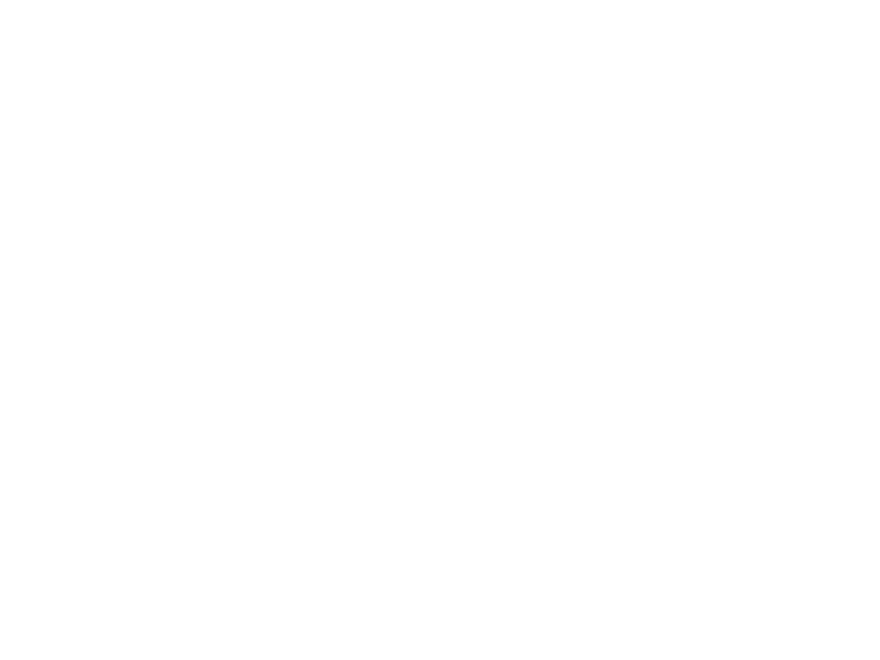

In [33]:
plot = show_scenes(left_a[0][0], collinear_a[0][0], right_a[0][0])
plot.draw()

# DLA ZESTAWU b)

In [42]:
left_b, collinear_b, right_b = classify(points_b)

In [43]:
show_results(left_b, collinear_b, right_b)

		POINTS POSITIONED:
for det 1 :  left:  50136  collinear:  0  right:  49864
for det 2 :  left:  50133  collinear:  5  right:  49862
for det 3 :  left:  50136  collinear:  0  right:  49864
for det 4 :  left:  50132  collinear:  6  right:  49862


## Dla wyznacznika numpy 3x3

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


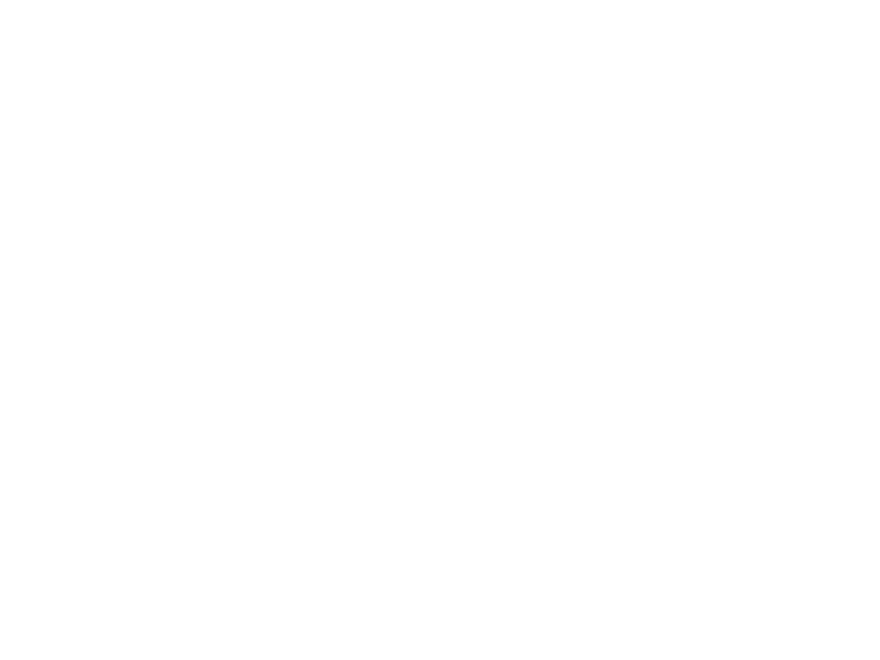

In [44]:
plot = show_scenes(left_b[0][0], collinear_b[0][0], right_b[0][0])
plot.draw()

## Dla wyznacznika numpy 2x2

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


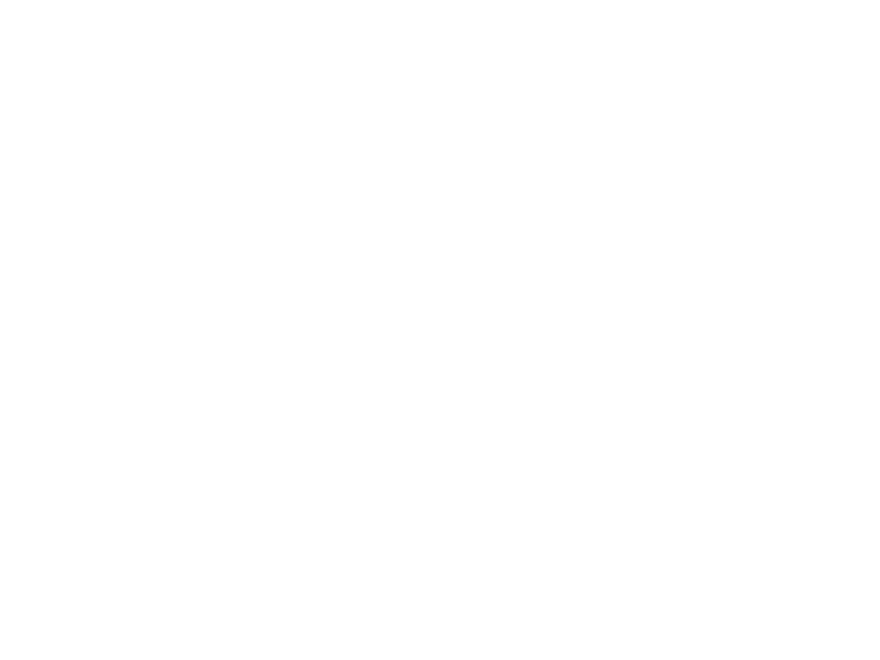

In [45]:
plot = show_scenes(left_b[1][0], collinear_b[1][0], right_b[1][0])
plot.draw()

## Dla mojego wyznacznika 3x3

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


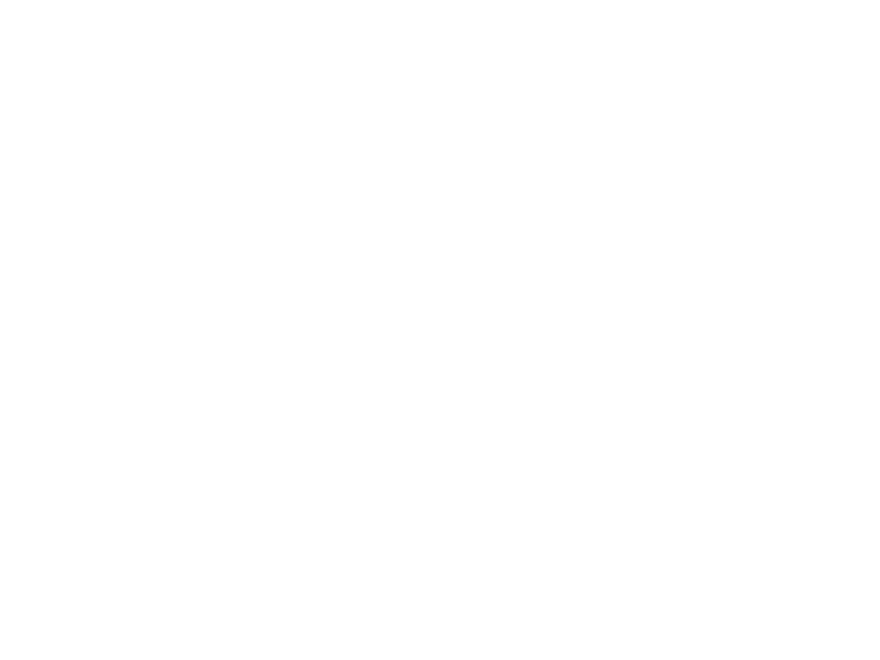

In [46]:
plot = show_scenes(left_b[2][0], collinear_b[2][0], right_b[2][0])
plot.draw()

## Dla mojego wyznacznika 2x2

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


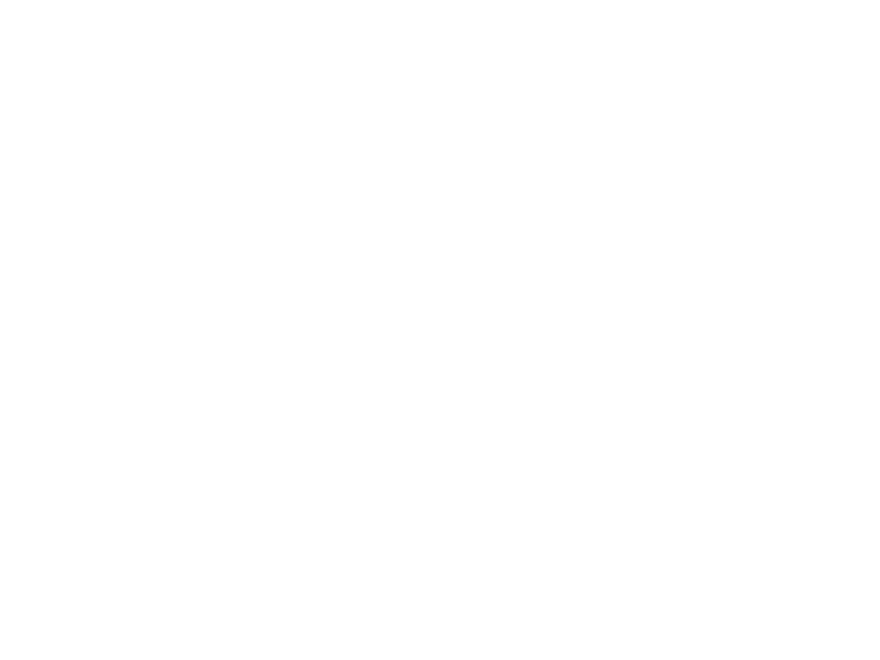

In [47]:
plot = show_scenes(left_b[3][0], collinear_b[3][0], right_b[3][0])
plot.draw()

# DLA ZESTAWU c)

In [48]:
left_c, collinear_c, right_c = classify(points_c)

In [49]:
show_results(left_c, collinear_c, right_c)

		POINTS POSITIONED:
for det 1 :  left:  496  collinear:  0  right:  504
for det 2 :  left:  496  collinear:  0  right:  504
for det 3 :  left:  496  collinear:  0  right:  504
for det 4 :  left:  496  collinear:  0  right:  504


## Wyniki prawie identyczne więc rysuje tylko dla liczenia wyznacznika 3x3 przez numpy

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


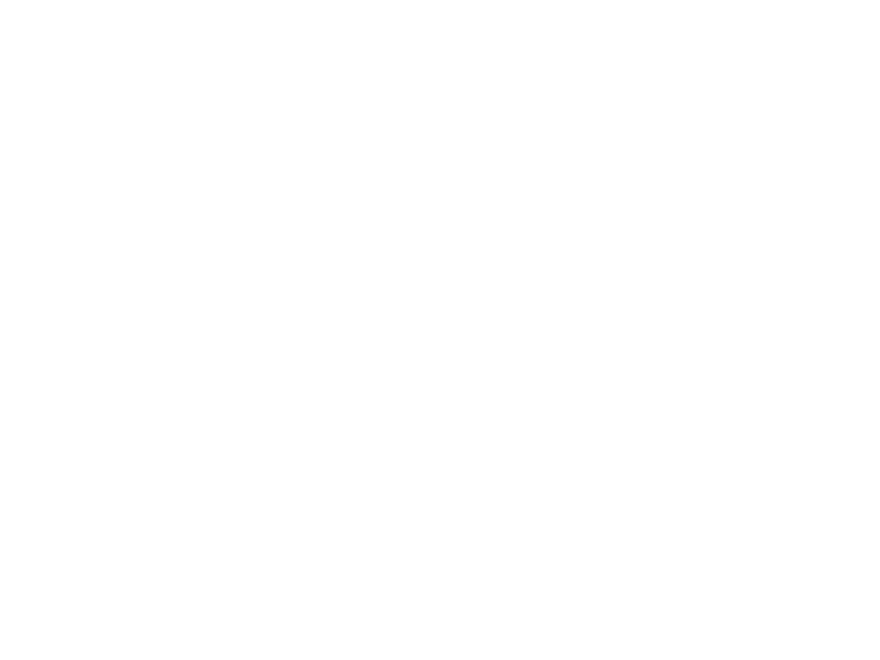

In [50]:
plot = show_scenes(left_c[0][0], collinear_c[0][0], right_c[0][0])
plot.draw()

# DLA ZESTAWU d)

In [51]:
left_d, collinear_d, right_d = classify(points_d)

In [52]:
show_results(left_d, collinear_d, right_d)

		POINTS POSITIONED:
for det 1 :  left:  450  collinear:  88  right:  462
for det 2 :  left:  175  collinear:  665  right:  160
for det 3 :  left:  376  collinear:  216  right:  408
for det 4 :  left:  143  collinear:  717  right:  140


## Dla wyznacznika numpy 3x3

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


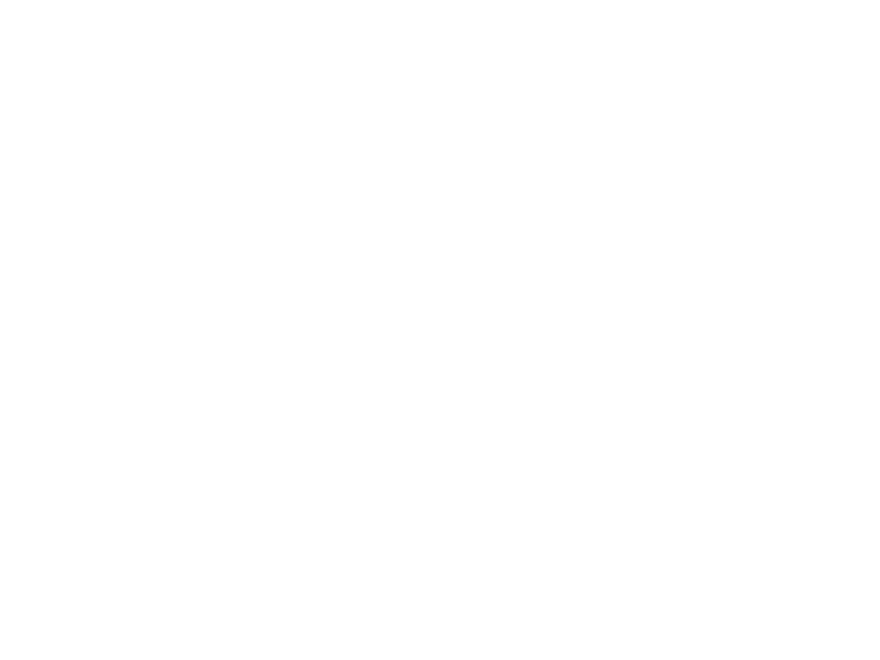

In [53]:
plot = show_scenes(left_d[0][0], collinear_d[0][0], right_d[0][0])
plot.draw()

## Dla wyznacznika numpy 2x2

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


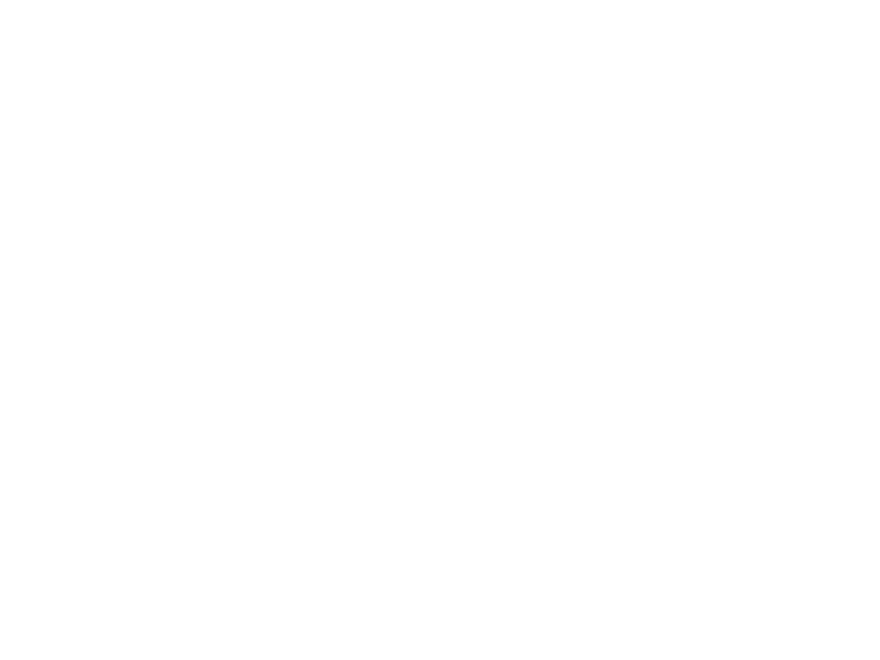

In [54]:
plot = show_scenes(left_d[1][0], collinear_d[1][0], right_d[1][0])
plot.draw()

## Dla mojego wyznacznika 3x3

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


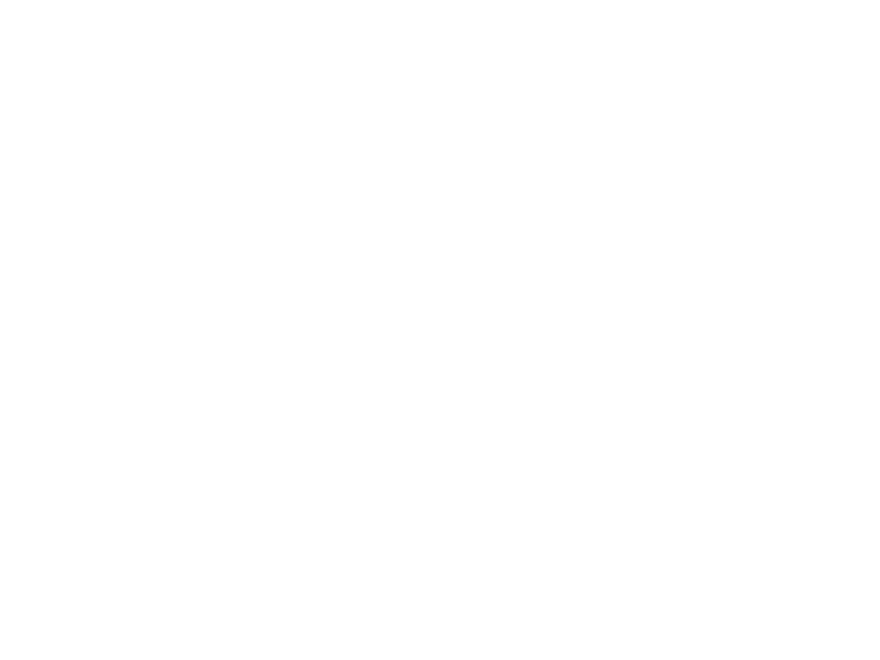

In [55]:
plot = show_scenes(left_d[2][0], collinear_d[2][0], right_d[2][0])
plot.draw()

## Dla mojego wyznacznika 2x2

left -> red, collinear -> blue, right -> green


<IPython.core.display.Javascript object>


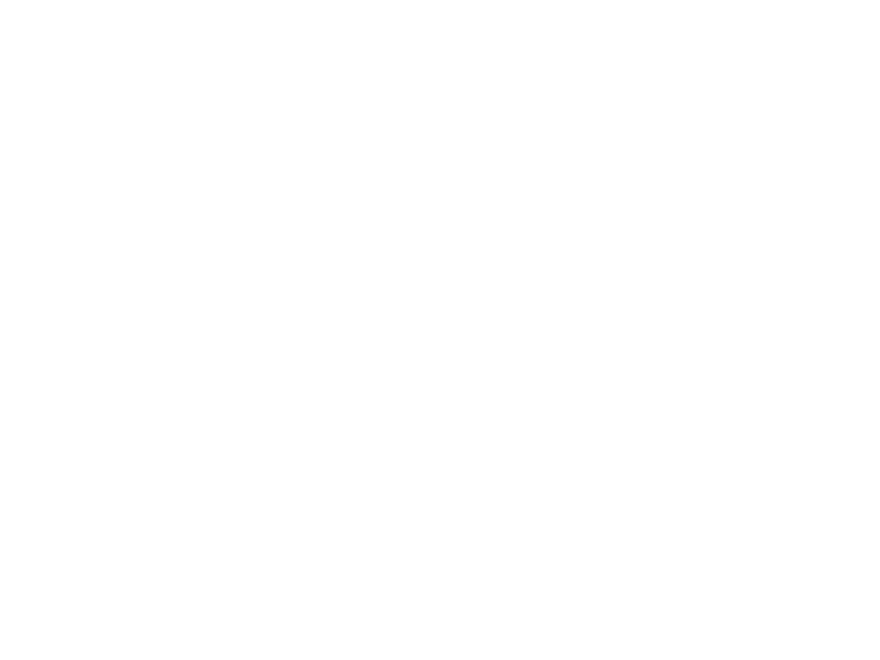

In [56]:
plot = show_scenes(left_d[3][0], collinear_d[3][0], right_d[3][0])
plot.draw()

# Różnice dla poszczególnych wyznaczników

### Funkcja difference przyjmuje tablicę punktów wraz z interesującymi nas parametrami i zwraca listę punktów różniących się (stała tolerancja ustawiona na 10e-18, index tolerancji t ustawiony na 0)

In [57]:
def difference(left, collinear, right, det1, det2, t=0):
    result = []
    
    set1 = []
    for x,y in left[det1][t]:
        set1.append((x, y, "left"))
    for x,y in collinear[det1][t]:
        set1.append((x, y, "collinear"))
    for x,y in right[det1][t]:
        set1.append((x, y, "right"))
    
    set2 = []
    for x,y in left[det2][t]:
        set2.append((x, y, "left"))
    for x,y in collinear[det2][t]:
        set2.append((x, y, "collinear"))
    for x,y in right[det2][t]:
        set2.append((x, y, "right"))
    
    set1.sort()
    set2.sort()
    
    for i in range(len(set1)):
        if set1[i][2] != set2[i][2]:
            result.append((set1[i][0], set1[i][1]))
    
    return result

## Funkcja show_difference rysuje różnice pomiędzy wyliczeniami za pomocą dwóch wyznaczników det1 i det2

In [58]:
def show_difference(left, collinear, right, det1, det2, tolerance=tolerances[0]):
    diff = difference(left, collinear, right, det1, det2)
    plot = Plot(points=[PointsCollection(diff)])
    plot.draw()
    print("Number of different: " + str(len(diff)))

## Funkcja show_difference_result wypisuje liczbę różnic pomiędzy kolejnymi wyznacznikami

In [59]:
def show_difference_result(left, collinear, right, tolerance=tolerances[0]):
    dets = ["numpy 3x3", "numpy 2x2", "mój 3x3", "mój 2x2"]
    diff = []
    for i in range(4):
        diff.append([])
        for j in range(4):
            diff[-1].append([])
    
    for i in range(4):
        for j in range(4):
            if i >= j: continue
            diff[i][j] = difference(left, collinear, right, i, j)
            print("number of diffrence between ", dets[i], " and ", dets[j], ": ", len(diff[i][j]))
    

# RÓŻNICE DLA POSZCZEGÓLNYCH ZESTAWÓW

# DLA ZESTAWU a)

In [60]:
show_difference_result(left_a, collinear_a, right_a)

number of diffrence between  numpy 3x3  and  numpy 2x2 :  0
number of diffrence between  numpy 3x3  and  mój 3x3 :  0
number of diffrence between  numpy 3x3  and  mój 2x2 :  0
number of diffrence between  numpy 2x2  and  mój 3x3 :  0
number of diffrence between  numpy 2x2  and  mój 2x2 :  0
number of diffrence between  mój 3x3  and  mój 2x2 :  0


## brak różnic dla zestawu a

# DLA ZESTAWU b)

In [61]:
show_difference_result(left_b, collinear_b, right_b)

number of diffrence between  numpy 3x3  and  numpy 2x2 :  5
number of diffrence between  numpy 3x3  and  mój 3x3 :  0
number of diffrence between  numpy 3x3  and  mój 2x2 :  6
number of diffrence between  numpy 2x2  and  mój 3x3 :  5
number of diffrence between  numpy 2x2  and  mój 2x2 :  7
number of diffrence between  mój 3x3  and  mój 2x2 :  6


## Różnice dla numpy 3x3 i numpy 2x2

<IPython.core.display.Javascript object>


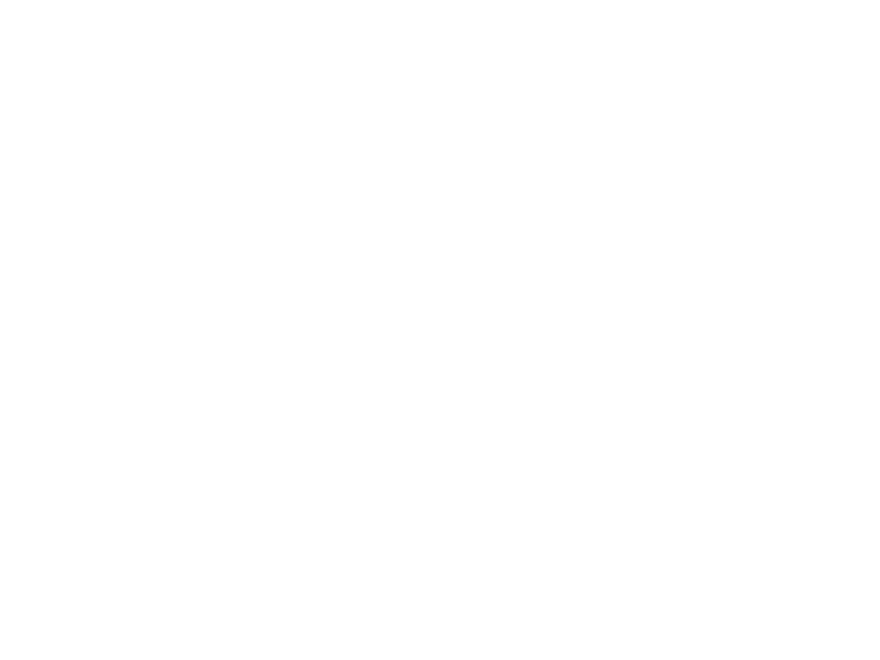

Number of different: 5


In [62]:
show_difference(left_b, collinear_b, right_b, 0, 1)

## Różnice dla numpy 3x3 i mój 2x2

<IPython.core.display.Javascript object>


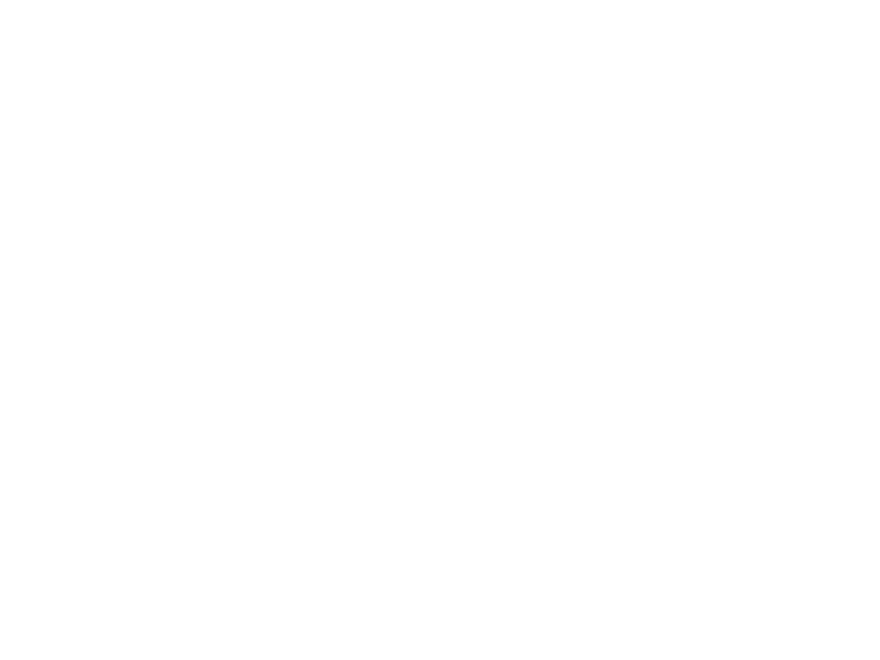

Number of different: 6


In [63]:
show_difference(left_b, collinear_b, right_b, 0, 3)

## Różnice dla numpy 2x2 i mój 3x3

<IPython.core.display.Javascript object>


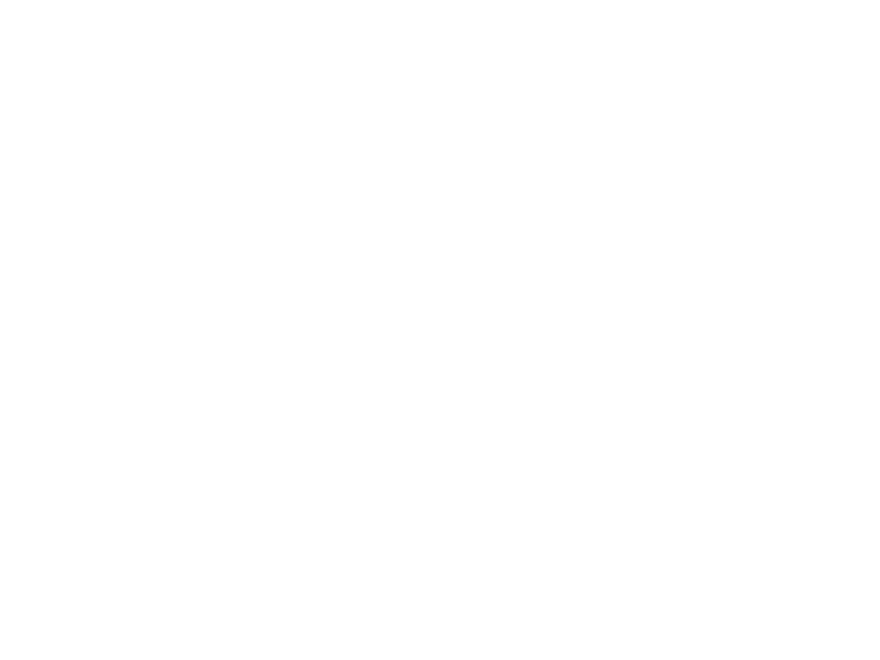

Number of different: 5


In [64]:
show_difference(left_b, collinear_b, right_b, 1, 2)

## Różnice dla numpy 2x2 i mój 2x2

<IPython.core.display.Javascript object>


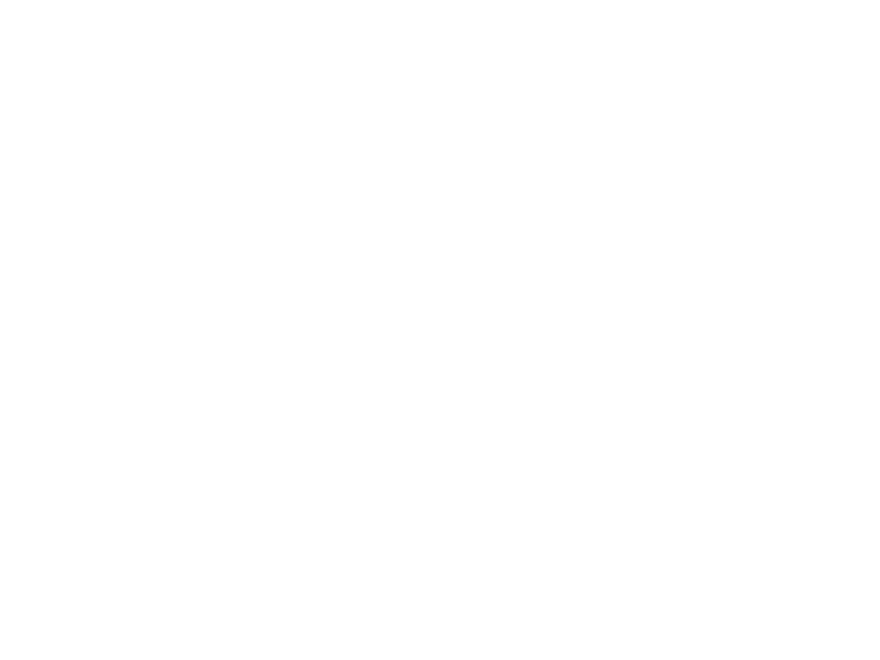

Number of different: 7


In [65]:
show_difference(left_b, collinear_b, right_b, 1, 3)

## Różnice dla mój 3x3 i mój 2x2

<IPython.core.display.Javascript object>


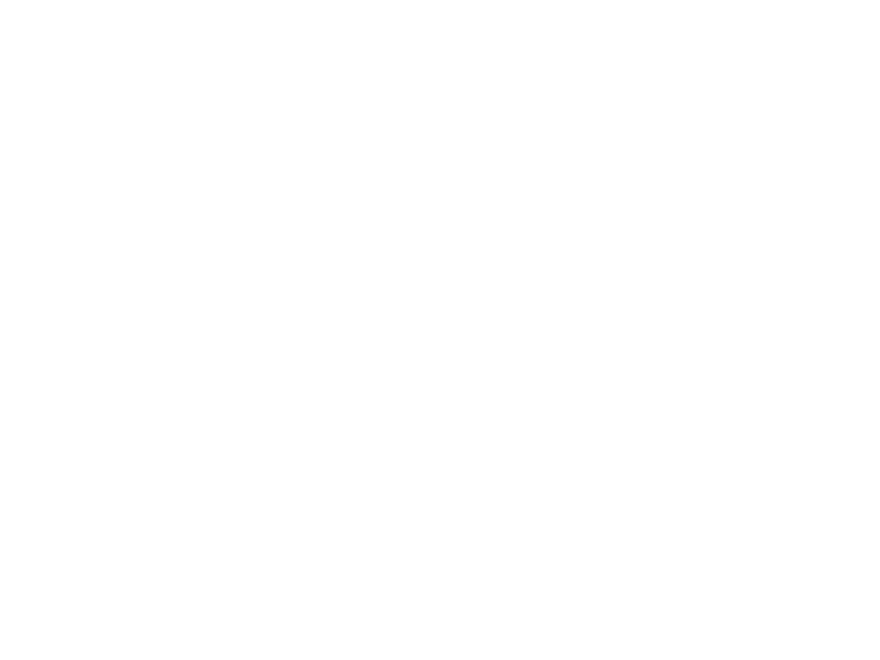

Number of different: 6


In [66]:
show_difference(left_b, collinear_b, right_b, 2, 3)

# DLA ZESTAWU c)

In [67]:
show_difference_result(left_c, collinear_c, right_c)

number of diffrence between  numpy 3x3  and  numpy 2x2 :  0
number of diffrence between  numpy 3x3  and  mój 3x3 :  0
number of diffrence between  numpy 3x3  and  mój 2x2 :  0
number of diffrence between  numpy 2x2  and  mój 3x3 :  0
number of diffrence between  numpy 2x2  and  mój 2x2 :  0
number of diffrence between  mój 3x3  and  mój 2x2 :  0


## brak różnic dla zestawu c

# DLA ZESTAWU d)

In [68]:
show_difference_result(left_d, collinear_d, right_d)

number of diffrence between  numpy 3x3  and  numpy 2x2 :  728
number of diffrence between  numpy 3x3  and  mój 3x3 :  262
number of diffrence between  numpy 3x3  and  mój 2x2 :  733
number of diffrence between  numpy 2x2  and  mój 3x3 :  646
number of diffrence between  numpy 2x2  and  mój 2x2 :  412
number of diffrence between  mój 3x3  and  mój 2x2 :  652


## Różnice dla numpy 3x3 i numpy 2x2

<IPython.core.display.Javascript object>


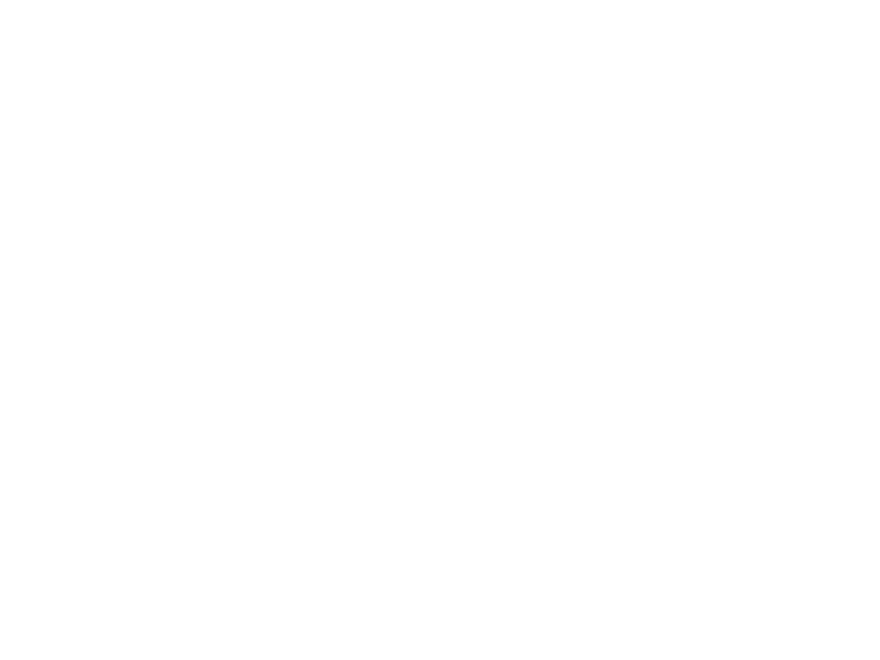

Number of different: 728


In [69]:
show_difference(left_d, collinear_d, right_d, 0, 1)

## Różnice dla numpy 3x3 i mój 3x3

<IPython.core.display.Javascript object>


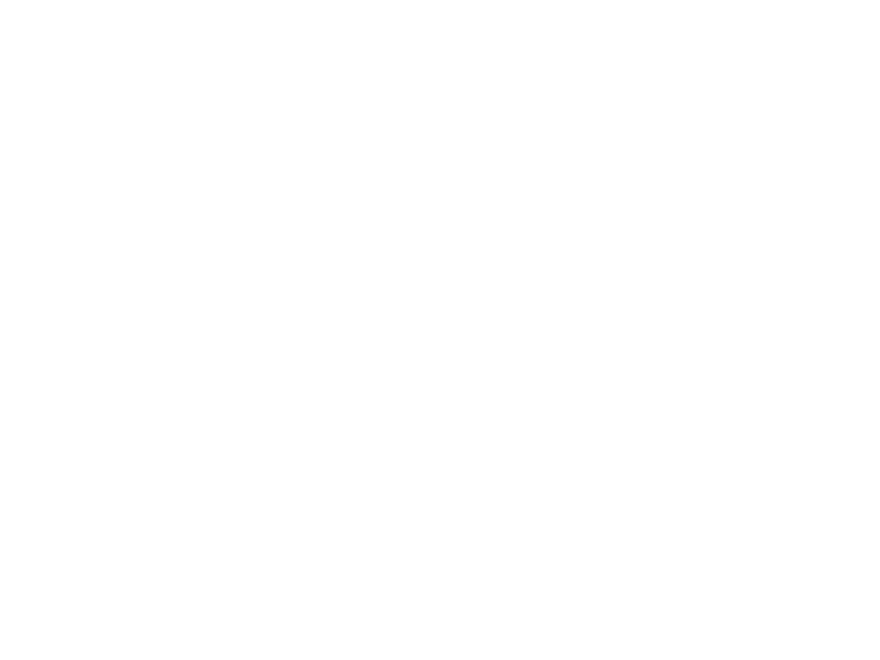

Number of different: 262


In [70]:
show_difference(left_d, collinear_d, right_d, 0, 2)

## Różnice dla numpy 3x3 i mój 2x2

<IPython.core.display.Javascript object>


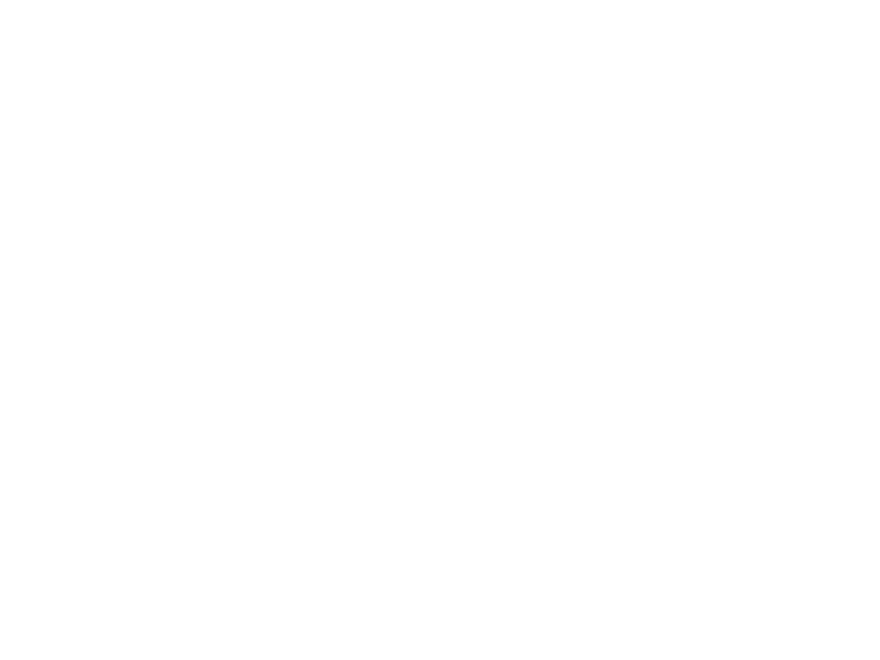

Number of different: 733


In [71]:
show_difference(left_d, collinear_d, right_d, 0, 3)

## Różnice dla numpy 2x2 i mój 3x3

<IPython.core.display.Javascript object>


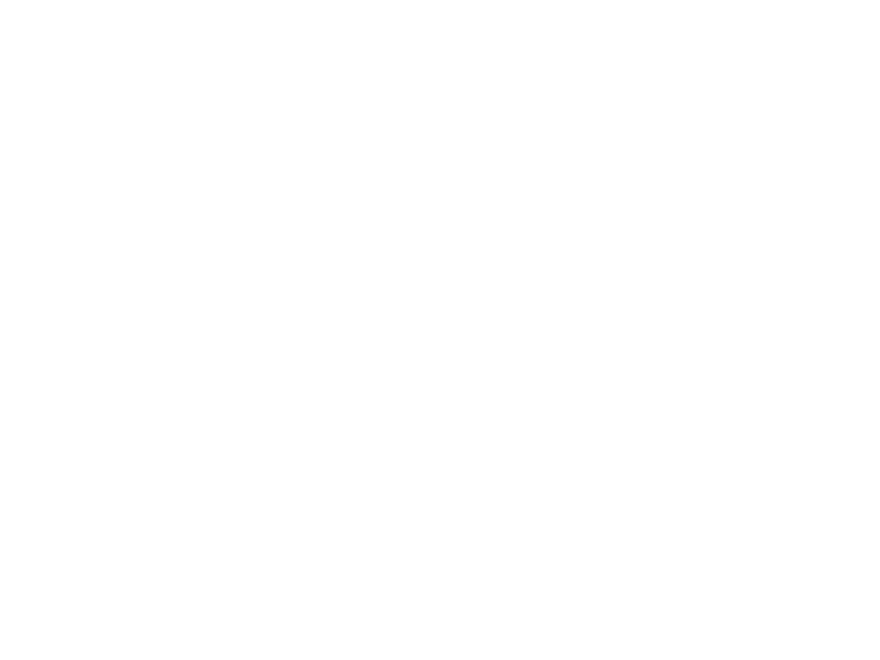

Number of different: 646


In [72]:
show_difference(left_d, collinear_d, right_d, 1, 2)

## Różnice dla numpy 2x2 i mój 2x2

<IPython.core.display.Javascript object>


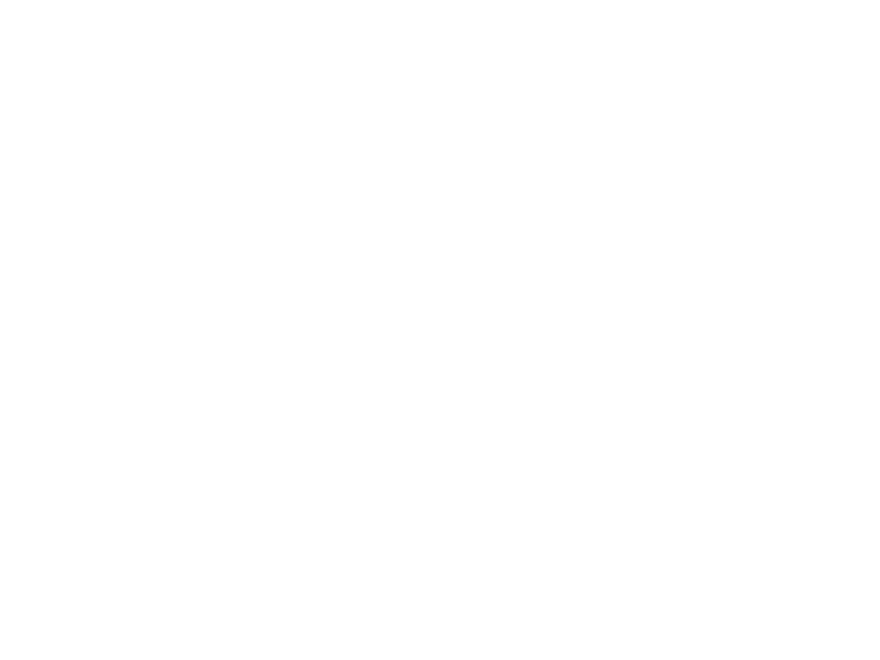

Number of different: 412


In [73]:
show_difference(left_d, collinear_d, right_d, 1, 3)

## Różnice dla mój 3x3 i mój 2x2

<IPython.core.display.Javascript object>


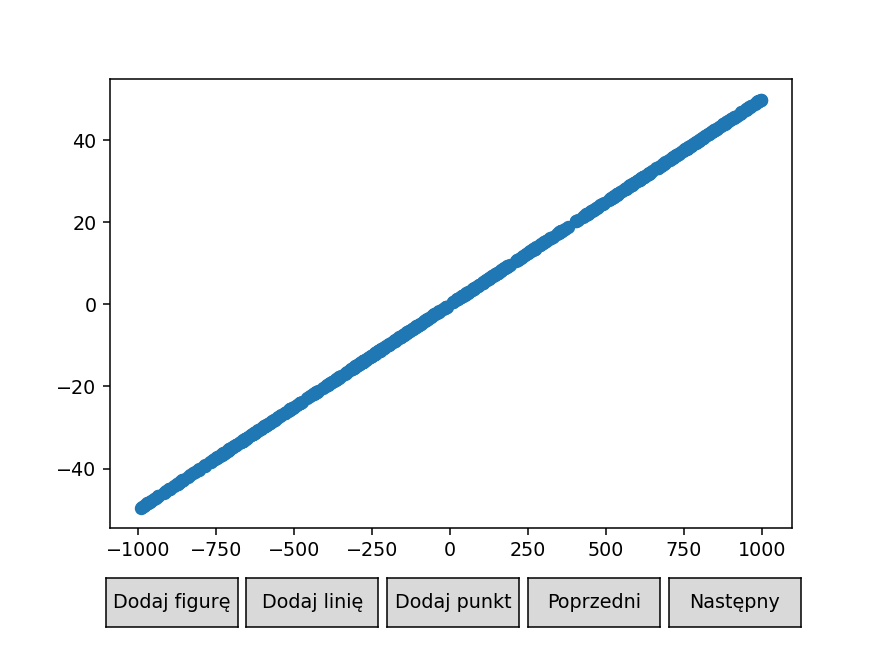

Number of different: 652


In [74]:
show_difference(left_d, collinear_d, right_d, 2, 3)


# ANALIZA różnych tolerancji dla zera

In [75]:
dets = ["numpy 3x3", "numpy 2x2", "mój 3x3", "mój 2x2"] 

def show_zero_tolerance_results(left, collinear, right):
    for i in range(4):
        print("Wyznacznik "+dets[i])
        for j in range(4):
            print("\tTolerancja "+str(tolerances[j])+
                  "\tLeft: " + str(len(left[i][j]))+ 
                  "\tCollinear: " + str(len(collinear[i][j]))+
                  "\tRight: " + str(len(right[i][j])))

# DLA ZESTAWU a)

In [76]:
show_zero_tolerance_results(left_a, collinear_a, right_a)

Wyznacznik numpy 3x3
	Tolerancja 1e-18	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-14	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-12	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-10	Left: 50157	Collinear: 0	Right: 49843
Wyznacznik numpy 2x2
	Tolerancja 1e-18	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-14	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-12	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-10	Left: 50157	Collinear: 0	Right: 49843
Wyznacznik mój 3x3
	Tolerancja 1e-18	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-14	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-12	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-10	Left: 50157	Collinear: 0	Right: 49843
Wyznacznik mój 2x2
	Tolerancja 1e-18	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-14	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-12	Left: 50157	Collinear: 0	Right: 49843
	Tolerancja 1e-10	Left: 50157	Collinear: 0	Right: 49843


# DLA ZESTAWU b)

In [77]:
show_zero_tolerance_results(left_b, collinear_b, right_b)

Wyznacznik numpy 3x3
	Tolerancja 1e-18	Left: 50136	Collinear: 0	Right: 49864
	Tolerancja 1e-14	Left: 50136	Collinear: 0	Right: 49864
	Tolerancja 1e-12	Left: 50136	Collinear: 0	Right: 49864
	Tolerancja 1e-10	Left: 50136	Collinear: 0	Right: 49864
Wyznacznik numpy 2x2
	Tolerancja 1e-18	Left: 50133	Collinear: 5	Right: 49862
	Tolerancja 1e-14	Left: 50133	Collinear: 5	Right: 49862
	Tolerancja 1e-12	Left: 50133	Collinear: 5	Right: 49862
	Tolerancja 1e-10	Left: 50133	Collinear: 5	Right: 49862
Wyznacznik mój 3x3
	Tolerancja 1e-18	Left: 50136	Collinear: 0	Right: 49864
	Tolerancja 1e-14	Left: 50136	Collinear: 0	Right: 49864
	Tolerancja 1e-12	Left: 50136	Collinear: 0	Right: 49864
	Tolerancja 1e-10	Left: 50136	Collinear: 0	Right: 49864
Wyznacznik mój 2x2
	Tolerancja 1e-18	Left: 50132	Collinear: 6	Right: 49862
	Tolerancja 1e-14	Left: 50132	Collinear: 6	Right: 49862
	Tolerancja 1e-12	Left: 50132	Collinear: 6	Right: 49862
	Tolerancja 1e-10	Left: 50132	Collinear: 6	Right: 49862


# DLA ZESTAWU c)

In [78]:
show_zero_tolerance_results(left_c, collinear_c, right_c)

Wyznacznik numpy 3x3
	Tolerancja 1e-18	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-14	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-12	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-10	Left: 496	Collinear: 0	Right: 504
Wyznacznik numpy 2x2
	Tolerancja 1e-18	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-14	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-12	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-10	Left: 496	Collinear: 0	Right: 504
Wyznacznik mój 3x3
	Tolerancja 1e-18	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-14	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-12	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-10	Left: 496	Collinear: 0	Right: 504
Wyznacznik mój 2x2
	Tolerancja 1e-18	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-14	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-12	Left: 496	Collinear: 0	Right: 504
	Tolerancja 1e-10	Left: 496	Collinear: 0	Right: 504


# DLA ZESTAWU d)

In [79]:
show_zero_tolerance_results(left_d, collinear_d, right_d)

Wyznacznik numpy 3x3
	Tolerancja 1e-18	Left: 450	Collinear: 88	Right: 462
	Tolerancja 1e-14	Left: 95	Collinear: 747	Right: 158
	Tolerancja 1e-12	Left: 0	Collinear: 1000	Right: 0
	Tolerancja 1e-10	Left: 0	Collinear: 1000	Right: 0
Wyznacznik numpy 2x2
	Tolerancja 1e-18	Left: 175	Collinear: 665	Right: 160
	Tolerancja 1e-14	Left: 163	Collinear: 689	Right: 148
	Tolerancja 1e-12	Left: 118	Collinear: 784	Right: 98
	Tolerancja 1e-10	Left: 0	Collinear: 1000	Right: 0
Wyznacznik mój 3x3
	Tolerancja 1e-18	Left: 376	Collinear: 216	Right: 408
	Tolerancja 1e-14	Left: 82	Collinear: 742	Right: 176
	Tolerancja 1e-12	Left: 0	Collinear: 1000	Right: 0
	Tolerancja 1e-10	Left: 0	Collinear: 1000	Right: 0
Wyznacznik mój 2x2
	Tolerancja 1e-18	Left: 143	Collinear: 717	Right: 140
	Tolerancja 1e-14	Left: 135	Collinear: 731	Right: 134
	Tolerancja 1e-12	Left: 76	Collinear: 834	Right: 90
	Tolerancja 1e-10	Left: 0	Collinear: 1000	Right: 0
